In [16]:
%pip install --quiet netket

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.


In [17]:
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"
import jax
import netket as nk
from netket.operator.spin import sigmax, sigmaz
import jax.numpy as jnp
import flax
from flax import nnx
import matplotlib.pyplot as plt
import flax.linen as nn
import netket.nn as nknn
import numpy as np
from math import sqrt
from scipy.sparse.linalg import eigsh


In [18]:
N = 20
hi = nk.hilbert.Spin(s=1 / 2, N=N)
graph = nk.graph.Hypercube(length=N, n_dim=1, pbc=True)

In [19]:


def H_Ising(hi_1, graph_1, g, J):
    H = sum([g * sigmax(hi_1, i) for i in graph_1.nodes()])
    H += sum([J * sigmaz(hi_1, i) * sigmaz(hi_1, j) for (i, j) in graph_1.edges()])
    return H


In [20]:
def train(vstate_1, hamiltonian):
    optimizer = nk.optimizer.Adam(learning_rate=0.01)
    gs = nk.driver.VMC(
        hamiltonian,
        optimizer,
        variational_state=vstate_1,
        preconditioner=nk.optimizer.SR(diag_shift=0.1),
    )

    log = nk.logging.RuntimeLog()
    gs.run(n_iter=300, out=log)


In [21]:
def mag_z(vstate_1, hi_1):
    return sum([np.abs(vstate_1.expect(sigmaz(hi_1, i)).mean) for i in range(N)] )/N

def mag_x(vstate_1, hi_1):
    return sum([np.abs(vstate_1.expect(sigmax(hi_1, i)).mean) for i in range(N)] )/N

In [22]:
# Define the ratio range from 0.1 to 10
n_data = 20
ratios = np.logspace(-1, 1, n_data)  # Logarithmically spaced values between 0.1 and 
ratios[int(n_data/2)] = 1
print(ratios)
# Iterate through the ratios and compute g and J
i = 0
energies = []
e_errors = []
mag_errors = []
mag_zs = []
mag_xs = []
crit_vstates = []  # for storing states in extreme values
for r in ratios:
    J = -1  # Keeping J constant at -1
    g = r * J  # Compute g based on the ratio
    
    H = H_Ising(hi, graph, g, J)
    sampler = nk.sampler.MetropolisLocal(hi)
    model = nk.models.RBM(alpha=10, use_visible_bias=True)
    vstate = nk.vqs.MCState(sampler, model, n_samples=4096)
    print(vstate.n_parameters)

    train(vstate, H)
    if i == 0 or i == (int(n_data/2)) or i == (n_data-1):
        crit_vstates.append(vstate)
    

    symm_energy = vstate.expect(H)
    mag_zs.append(mag_z(vstate, hi))
    mag_xs.append(mag_x(vstate, hi))

    e = float(symm_energy.mean)
    
    energies.append(e)
    e_errors.append(float(symm_energy.error_of_mean))

    print(f"i: {i}, g: {g:.4f}, J: {J:.4f}, ratio: {r:.4f}, energy: {e:.4f}, ") #magnetization: {m:4g}
    i += 1


[ 0.1         0.1274275   0.16237767  0.20691381  0.26366509  0.33598183
  0.42813324  0.54555948  0.6951928   0.88586679  1.          1.43844989
  1.83298071  2.33572147  2.97635144  3.79269019  4.83293024  6.15848211
  7.8475997  10.        ]
4220


  0%|          | 0/300 [00:00<?, ?it/s]

i: 0, g: -0.1000, J: -1.0000, ratio: 0.1000, energy: -20.0052, 
4220


  0%|          | 0/300 [00:00<?, ?it/s]

i: 1, g: -0.1274, J: -1.0000, ratio: 0.1274, energy: -16.0041, 
4220


  0%|          | 0/300 [00:00<?, ?it/s]

i: 2, g: -0.1624, J: -1.0000, ratio: 0.1624, energy: -16.3984, 
4220


  0%|          | 0/300 [00:00<?, ?it/s]

i: 3, g: -0.2069, J: -1.0000, ratio: 0.2069, energy: -16.7655, 
4220


  0%|          | 0/300 [00:00<?, ?it/s]

i: 4, g: -0.2637, J: -1.0000, ratio: 0.2637, energy: -17.0148, 
4220


  0%|          | 0/300 [00:00<?, ?it/s]

i: 5, g: -0.3360, J: -1.0000, ratio: 0.3360, energy: -20.5684, 
4220


  0%|          | 0/300 [00:00<?, ?it/s]

i: 6, g: -0.4281, J: -1.0000, ratio: 0.4281, energy: -20.9272, 
4220


  0%|          | 0/300 [00:00<?, ?it/s]

i: 7, g: -0.5456, J: -1.0000, ratio: 0.5456, energy: -21.5178, 
4220


  0%|          | 0/300 [00:00<?, ?it/s]

i: 8, g: -0.6952, J: -1.0000, ratio: 0.6952, energy: -22.4970, 
4220


  0%|          | 0/300 [00:00<?, ?it/s]

i: 9, g: -0.8859, J: -1.0000, ratio: 0.8859, energy: -24.1793, 
4220


  0%|          | 0/300 [00:00<?, ?it/s]

i: 10, g: -1.0000, J: -1.0000, ratio: 1.0000, energy: -25.4868, 
4220


  0%|          | 0/300 [00:00<?, ?it/s]

i: 11, g: -1.4384, J: -1.0000, ratio: 1.4384, energy: -32.3666, 
4220


  0%|          | 0/300 [00:00<?, ?it/s]

i: 12, g: -1.8330, J: -1.0000, ratio: 1.8330, energy: -39.4427, 
4220


  0%|          | 0/300 [00:00<?, ?it/s]

i: 13, g: -2.3357, J: -1.0000, ratio: 2.3357, energy: -48.8805, 
4220


  0%|          | 0/300 [00:00<?, ?it/s]

i: 14, g: -2.9764, J: -1.0000, ratio: 2.9764, energy: -61.2187, 
4220


  0%|          | 0/300 [00:00<?, ?it/s]

i: 15, g: -3.7927, J: -1.0000, ratio: 3.7927, energy: -77.1784, 
4220


  0%|          | 0/300 [00:00<?, ?it/s]

i: 16, g: -4.8329, J: -1.0000, ratio: 4.8329, energy: -97.6960, 
4220


  0%|          | 0/300 [00:00<?, ?it/s]

i: 17, g: -6.1585, J: -1.0000, ratio: 6.1585, energy: -123.9819, 
4220


  0%|          | 0/300 [00:00<?, ?it/s]

i: 18, g: -7.8476, J: -1.0000, ratio: 7.8476, energy: -157.5896, 
4220


  0%|          | 0/300 [00:00<?, ?it/s]

i: 19, g: -10.0000, J: -1.0000, ratio: 10.0000, energy: -200.5007, 


/tmp/ipykernel_1298/2420981325.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


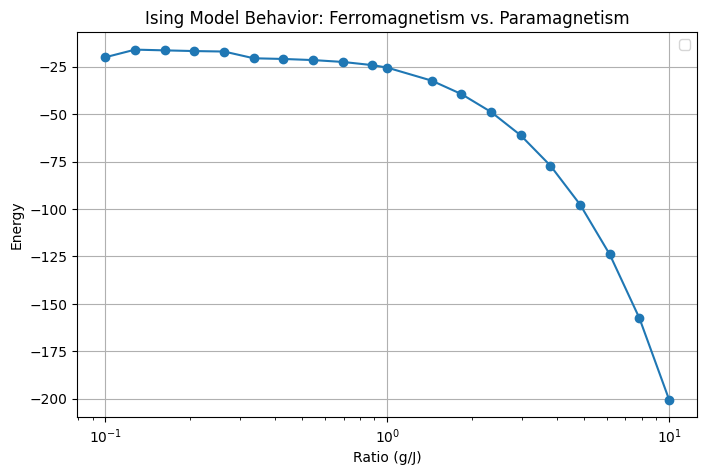

In [23]:

plt.figure(figsize=(8, 5))
plt.plot(ratios, energies, marker='o', linestyle='-')
plt.xscale('log')  # Logarithmic scale for better visualization
plt.xlabel("Ratio (g/J)")
plt.ylabel("Energy")
plt.title("Ising Model Behavior: Ferromagnetism vs. Paramagnetism")
plt.legend()
plt.grid(True)
plt.show()

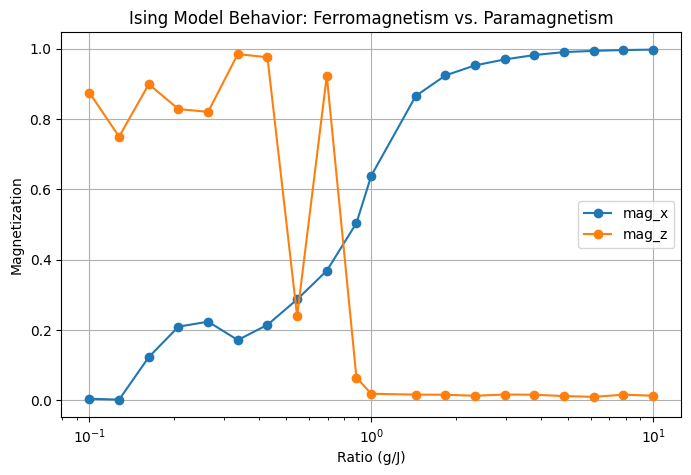

In [24]:


err = list(map(lambda x: abs(x), mag_errors))
plt.figure(figsize=(8, 5))

plt.plot(ratios, mag_xs, marker='o', linestyle='-', label='mag_x')
plt.plot(ratios, mag_zs, marker='o', linestyle='-', label='mag_z')
plt.xscale('log') 
plt.xlabel("Ratio (g/J)")
plt.ylabel("Magnetization")
plt.title("Ising Model Behavior: Ferromagnetism vs. Paramagnetism")
plt.legend()
plt.grid(True)
plt.show()

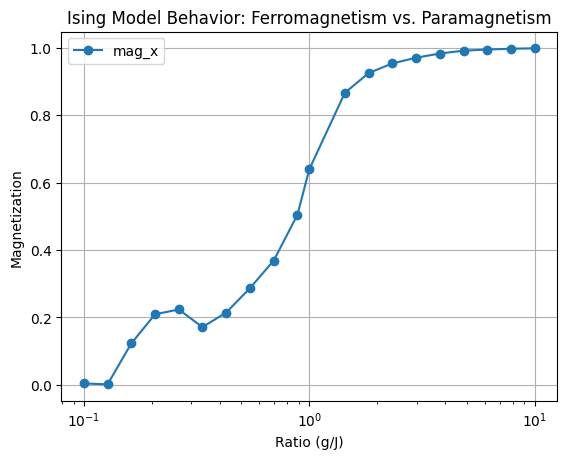

In [25]:
plt.plot(ratios, mag_xs, marker='o', linestyle='-', label='mag_x')
plt.xscale('log')
plt.xlabel("Ratio (g/J)")
plt.ylabel("Magnetization")
plt.title("Ising Model Behavior: Ferromagnetism vs. Paramagnetism")
plt.legend()
plt.grid(True)
plt.show()

Calculate the correlation between 0 and [0, 1,..., N]
$$\langle S^{z}_iS^{z}_{i+1} \rangle=\frac{1}{4} \langle \sigma^{z}_{i} \sigma^{z}_{i+1} \rangle$$
We calculate the correlation between the spins of the first site and all the others 
$$\langle S^{z}_0S^{z}_{n} \rangle,\; n\in \left[0,1,...,N\right]$$

In [26]:
def corr0_z(hi_1, vstate_1):
    
    return [1/4 * vstate_1.expect(sigmaz(hi_1, 0) * sigmaz(hi_1, i)).mean for i in range(N)]

def corr0_x(hi_1, vstate_1):
    return [1/4 * vstate_1.expect(sigmax(hi_1, 0) * sigmax(hi_1, i)).mean for i in range(N)]  

In [27]:
ferro_corr_x = corr0_x(hi, crit_vstates[0])
crit_corr_x = corr0_x(hi, crit_vstates[1])
para_corr_x = corr0_x(hi, crit_vstates[2])
ferro_corr_z = corr0_z(hi, crit_vstates[0])
crit_corr_z = corr0_z(hi, crit_vstates[1])
para_corr_z = corr0_z(hi, crit_vstates[2])

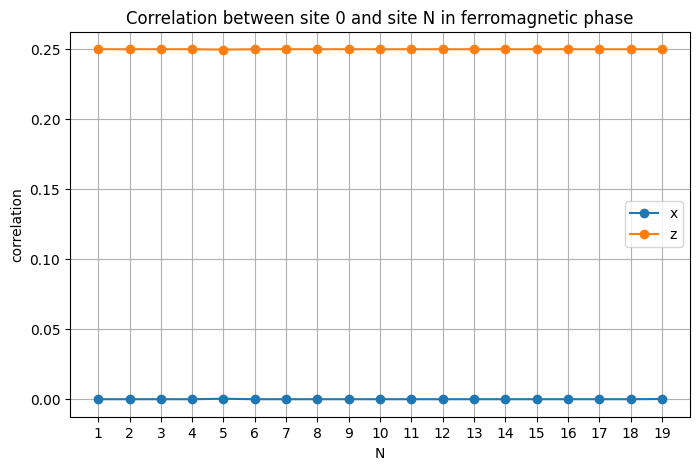

In [28]:
x = range(1, N)
plt.figure(figsize=(8, 5))
plt.plot(x, ferro_corr_x[1:], marker='o', linestyle='-', label='x')
plt.plot(x, ferro_corr_z[1:], marker='o', linestyle='-', label='z')
plt.xlabel("N")
plt.ylabel("correlation")
plt.title("Correlation between site 0 and site N in ferromagnetic phase")
plt.legend()
plt.grid(True)
plt.xticks(x)
plt.show()

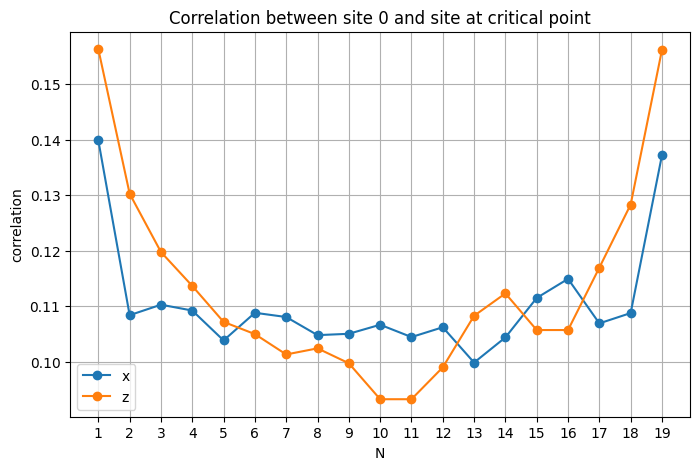

In [29]:
x = range(1, N)
plt.figure(figsize=(8, 5))
plt.plot(x, crit_corr_x[1:], marker='o', linestyle='-', label='x')
plt.plot(x, crit_corr_z[1:], marker='o', linestyle='-', label='z')
plt.xlabel("N")
plt.ylabel("correlation")
plt.title("Correlation between site 0 and site at critical point")
plt.legend()
plt.grid(True)
plt.xticks(x)
plt.show()

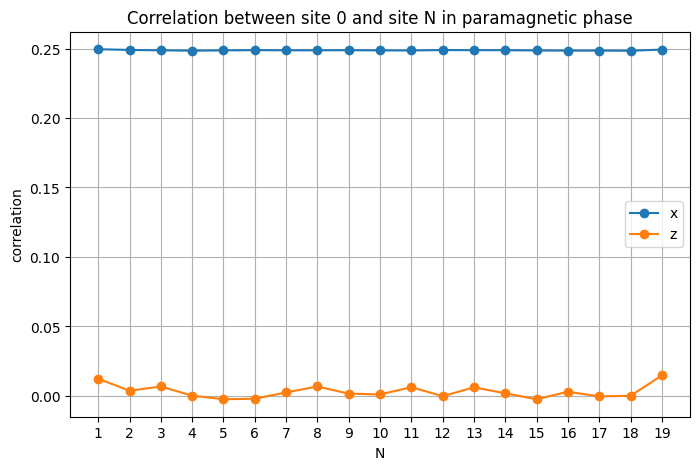

In [30]:
x = range(1, N)
plt.figure(figsize=(8, 5))
plt.plot(x, para_corr_x[1:], marker='o', linestyle='-', label='x')
plt.plot(x, para_corr_z[1:], marker='o', linestyle='-', label='z')
plt.xlabel("N")
plt.ylabel("correlation")
plt.title("Correlation between site 0 and site N in paramagnetic phase")
plt.legend()
plt.grid(True)
plt.xticks(x)
plt.show()